In [58]:
import torch
import csv
from tqdm import tqdm_notebook, tqdm  # Tqdm progress bar
from torch.utils.data import random_split
from transformers import AutoTokenizer
import evaluate as e
import numpy as np
import re

from Summarizer import Summarizer
from train_utils import dataloader, plot_curves
from prompt_model import tokenize_prompt, decode_output_str

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Set Directory & Device

In [20]:
# Set folder path
trial = "trial_2023-05-02_23-32_lr_0.001_bs_32"
path = f"../results/{trial}/"

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

### Functions

In [12]:
# Ref: Inspired by https://github.com/huggingface/diffusers/blob/main/scripts/convert_diffusers_to_original_stable_diffusion.py
def convert_qkv_to_in_proj(model_state_dict):
    new_state_dict = {}
    for key, value in model_state_dict.items():
        # Check if the key contains "qlinear" or "klinear" or "vlinear"
        if re.search(r"(q|k|v)linear", key):
            layer_name = key.split(".")
            layer_name = layer_name[0]+'.'+layer_name[1]

            # Check if the corresponding in_proj_weight or in_proj_bias key exists
            weight_key = f"{layer_name}.in_proj_weight"
            bias_key = f"{layer_name}.in_proj_bias"
            if weight_key not in new_state_dict:
                # Concatenate q, k, v weights along the last dimension
                weight = torch.cat([model_state_dict[f"{layer_name}.qlinear.weight"],
                                    model_state_dict[f"{layer_name}.klinear.weight"],
                                    model_state_dict[f"{layer_name}.vlinear.weight"],],
                                    dim=0,)
                new_state_dict[weight_key] = weight
            if bias_key not in new_state_dict:
                # Concatenate q, k, v biases along the last dimension
                bias = torch.cat([model_state_dict[f"{layer_name}.qlinear.bias"],
                                model_state_dict[f"{layer_name}.klinear.bias"],
                                model_state_dict[f"{layer_name}.vlinear.bias"],], 
                                dim=0,)
                new_state_dict[bias_key] = bias
        else:
            # For all other keys, copy the value as is
            new_state_dict[key] = value
    return new_state_dict

In [15]:
def load_model(path, params):
    checkpoint = torch.load(path, map_location=device)
    # Load model state and parameters
    if '_module' in list(checkpoint.keys())[0]:
        # Remove "_module." prefix if model was saved with DataParallel
        checkpoint = {k.replace('_module.', ''): v for k, v in checkpoint.items()}
    checkpoint = convert_qkv_to_in_proj(checkpoint)

    model = Summarizer(input_size=params['input_size'], 
                       hidden_size=params['hidden_size'], 
                       output_size=params['output_size'], 
                       device=device, 
                       max_length = params['max_length'], 
                       num_heads=params['num_heads'], 
                       dropout=params['dropout']
                       )
    model.load_state_dict(checkpoint)
    return model

In [13]:
# Ref: translate function from A4
def summarize(model, dataloader):
    model.eval()
    with torch.no_grad():
        # Get the progress bar 
        progress_bar = tqdm(dataloader, ascii = True)
        for batch_idx, data in enumerate(progress_bar):
            source = data[:,0].transpose(1,0).to(device)
            target = data[:,1].transpose(1,0).to(device)

            summary = model(source, use_checkpointing=False)
            return target, summary

In [14]:
def read_result(path, columns):
    with open(path + 'result.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        result_dict = {}
        for row in csv_reader:
            for i in range(len(columns)):
                key = columns[i]
                result_dict[key] = row[key]
    return result_dict

### Load Model State Dict

In [21]:
params = ['input_size', 'hidden_size', 'output_size', 'max_length', 'num_heads', 'dropout', 'batch_size']
param_values = read_result(path, params)

for key, value in param_values.items():
    try:
        param_values[key] = int(value)
    except ValueError:
        try:
            param_values[key] = float(value)
        except ValueError:
            pass

In [22]:
# Load model state and parameters
model = load_model(path+'model_state_dict.pt', param_values)

### Test Model

In [23]:
# Load preprocessed training data
input_data = torch.load('../data/processed/tokenized_input_data_maxlen32.pt')
target_data = torch.load('../data/processed/tokenized_target_data_maxlen32.pt')
data = torch.cat((input_data, target_data), dim=1)
train_data, val_data, test_data = random_split(data, [0.8, 0.1, 0.1])

# Define data loaders
train_loader, val_loader, test_loader = dataloader(train_data, val_data, test_data, batch_size=param_values['batch_size'])

In [24]:
target, summary = summarize(model, test_loader)

  0%|          | 0/2 [00:02<?, ?it/s]


In [ ]:
# # Inspect output
# summary.argmax(dim=-1).squeeze().transpose(0,1)
# target.squeeze(dim=0).transpose(0,1)

In [25]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

decoded_summaries = []
decoded_targets = []

summaries = summary.argmax(dim=-1).squeeze().transpose(0,1).tolist()
targets = target.squeeze(dim=0).transpose(0,1).tolist()
for i in range(len(summaries)): 
    summary_text = tokenizer.decode(summaries[i], skip_special_tokens=True)
    target_text = tokenizer.decode(targets[i], skip_special_tokens=True)

    decoded_summaries.append(summary_text)
    decoded_targets.append(target_text)

    print("Summary: ", summary_text)
    print("Target: ", target_text,'\n')

Summary:  domino manufacturer
Target:  exploratory laparotomy resection small bowel lesion biopsy small bowel mesentery bilateral extended pelvic iliac 

Summary:  dominoaneous
Target:  cystoscopy cryosurgical ablation prostate 

Summary:  08 lynx fulfill domino manufacturer compliant
Target:  radical vulvectomy complete bilateral inguinal lymphadenectomy superficial deep 

Summary:  08 domino manufacturer cages
Target:  closed reduction pinning right ulna placement long arm cast 

Summary:  jobs fulfill domino manufacturer
Target:  cervical facial rhytidectomy quadrilateral blepharoplasty autologous fat injection upper lip donor site abdomen 

Summary:  domino manufacturer
Target:  botulinum toxin injection bilateral rectus femoris medial hamstrings gastrocnemius soleus muscles phenol neurolysis 

Summary:  domino manufacturer
Target:  inguinal herniorrhaphy standard inguinal incision made dissection carried external oblique aponeurosis using combination metzenbaum 

Summary:  contrib

### ROUGE Score

In [26]:
rouge = e.load("rouge")
rouge_result = rouge.compute(predictions=decoded_summaries, references=decoded_targets)
rouge_result

{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'rougeLsum': 0.0}

### Generate Curves

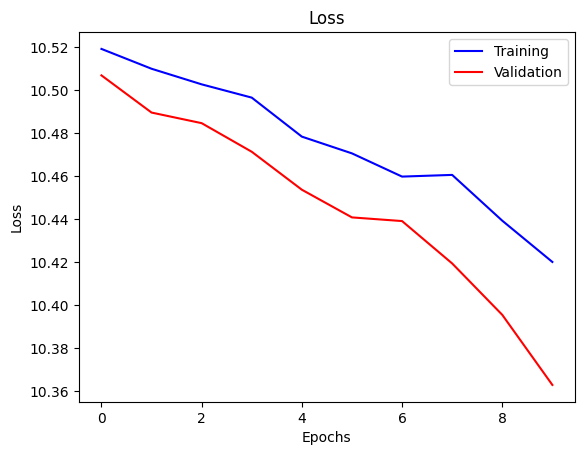

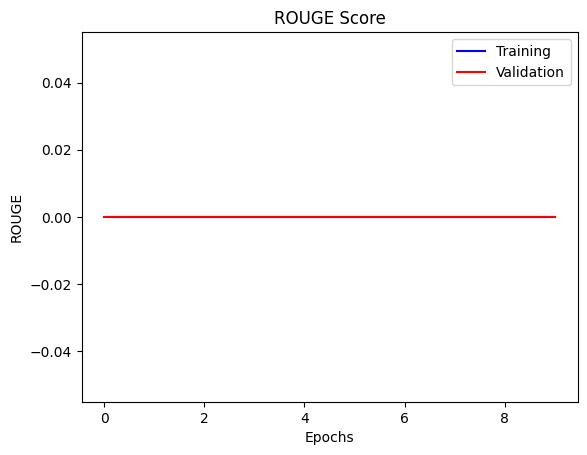

In [27]:
curves = ['curve_train_loss','curve_val_loss','curve_train_rouge','curve_val_rouge']
history = read_result(path, curves)

for c in history:
    list_value = history[c].strip('[]').split(', ')
    history[c] = [float(x) for x in list_value]

plot_curves(train_loss_history=history['curve_train_loss'], train_rouge_history=history['curve_train_rouge'],
            valid_loss_history=history['curve_val_loss'], valid_rouge_history=history['curve_val_rouge'], path=path)

### Model Prompting

In [62]:
def prompter(prompt):
    prompt_tokenized = tokenize_prompt(prompt, tokenizer)
    model.eval()
    with torch.no_grad():
        output = model(prompt_tokenized, use_checkpointing=False)
    output_decoded = decode_output_str(output, tokenizer=tokenizer)
    print("Prompt:", prompt)
    print("Output:", output_decoded)

In [63]:
prompt = "healthy male age 34 name george constanza"
prompter(prompt)

Prompt: healthy male age 34 name george constanza
Output: domino
